In [1]:
import nest_asyncio
from langgraph.graph import START, StateGraph
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from typing import Literal
from langchain_core.messages import AIMessage
import os
from openai import OpenAI
from dotenv import load_dotenv
from nodes import assistant, summarize_packets, execute_tools, save_iteration_node
from state import HoneypotStateReact
from memory import EpisodicMemory
nest_asyncio.apply()
import benchmark as b



def display_graph(graph, width=500, height=600):

    png_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)

    display(Image(data=png_bytes, format="png", width=width, height=height)
)

def is_api_key_valid():
    try:
        client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
        response = client.responses.create(
            model="gpt-4o",
            instructions="Test API key",
            input="Test API key",
            max_output_tokens=16,
            timeout=10
            )
    except Exception as e:
        print(f"Error: {e}")
        return False
    else:
        return True

In [2]:

# Load environment variables
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
#  Check the validity of the API key
api_key_valid = is_api_key_valid()
print("API key is valid:", api_key_valid)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"


API key is valid: True


# Memory implementation

In [3]:
def should_continue_from_assistant(state: HoneypotStateReact) -> Literal["tools", "save_iteration", "cleanup", "__end__"]:
    last_message = state.messages[-1]
    
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    
    # if state.network_flows and state.security_events and state.compressed_packets and not state.packet_summary:
    #     return "threat_verification"
    
    if (len(state.packet_summary) > 1 and len(state.messages) > 1 and 
        not state.cleanup_flag and (not hasattr(last_message, 'tool_calls') or not last_message.tool_calls)) \
            and "ITERATION SUMMARY" in last_message.content:
        return "save_iteration"
    
    if not state.cleanup_flag and len(state.messages) > 1 and len(state.packet_summary) > 1:
        return "cleanup"

    return "__end__"

def should_continue_from_tools(state: HoneypotStateReact) -> Literal["threat_verification", "assistant"]:
    # After tools are executed, decide where to go next
    if state.network_flows and state.security_events and state.compressed_packets and not state.packet_summary:
        return "threat_verification"
    return "assistant"


In [ ]:
def cleanup_messages(state: HoneypotStateReact):
    """Clean up ALL messages and data, keeping only essential state for next iteration"""
    print("Performing complete cleanup before ending iteration...")
    
    if state.messages:
        print("Flushing all messages and resetting state for next iteration")
        
        return {
            "messages": state.messages[-1],  # Flush all messages
            "packet_summary": {},  # Clear packet summary
            "network_flows": {},  # Clear network flows
            "security_events": {},  # Clear security events
            "compressed_packets": {},  # Clear compressed packets
            "firewall_config": "",  # Will be reloaded in next iteration
            "honeypot_config": "",  # Will be reloaded in next iteration
            "firewall_status": "",  # Will be reloaded in next iteration
            "monitor_status": "",  # Will be reloaded in next iteration
            "memory_context": [],  # Will be reloaded in next iteration
            "cleanup_flag": True
        }
    else:
        print("No messages to cleanup")
        return {}

In [5]:
def build_react_graph():
    builder = StateGraph(HoneypotStateReact)
    
    # Add nodes
    builder.add_node("assistant", assistant)
    builder.add_node("tools", execute_tools)
    builder.add_node("threat_verification", summarize_packets)
    builder.add_node("save_iteration", save_iteration_node)  # NEW: Save iteration node
    builder.add_node("cleanup", cleanup_messages)  # Modified cleanup
    
    # Add edges
    builder.add_edge(START, "assistant")
    builder.add_conditional_edges("assistant", should_continue_from_assistant)
    builder.add_conditional_edges("tools", should_continue_from_tools)
    builder.add_edge("threat_verification", "assistant")
    builder.add_edge("save_iteration", "cleanup")  # NEW: Save iteration then cleanup
    builder.add_edge("cleanup", "__end__")  # Cleanup then end
        
    return builder.compile()

INFO:pyppeteer.launcher:Browser listening on: ws://127.0.0.1:52325/devtools/browser/a85222b6-30a9-48ce-baef-e970c58bd064
INFO:pyppeteer.launcher:terminate chrome process...


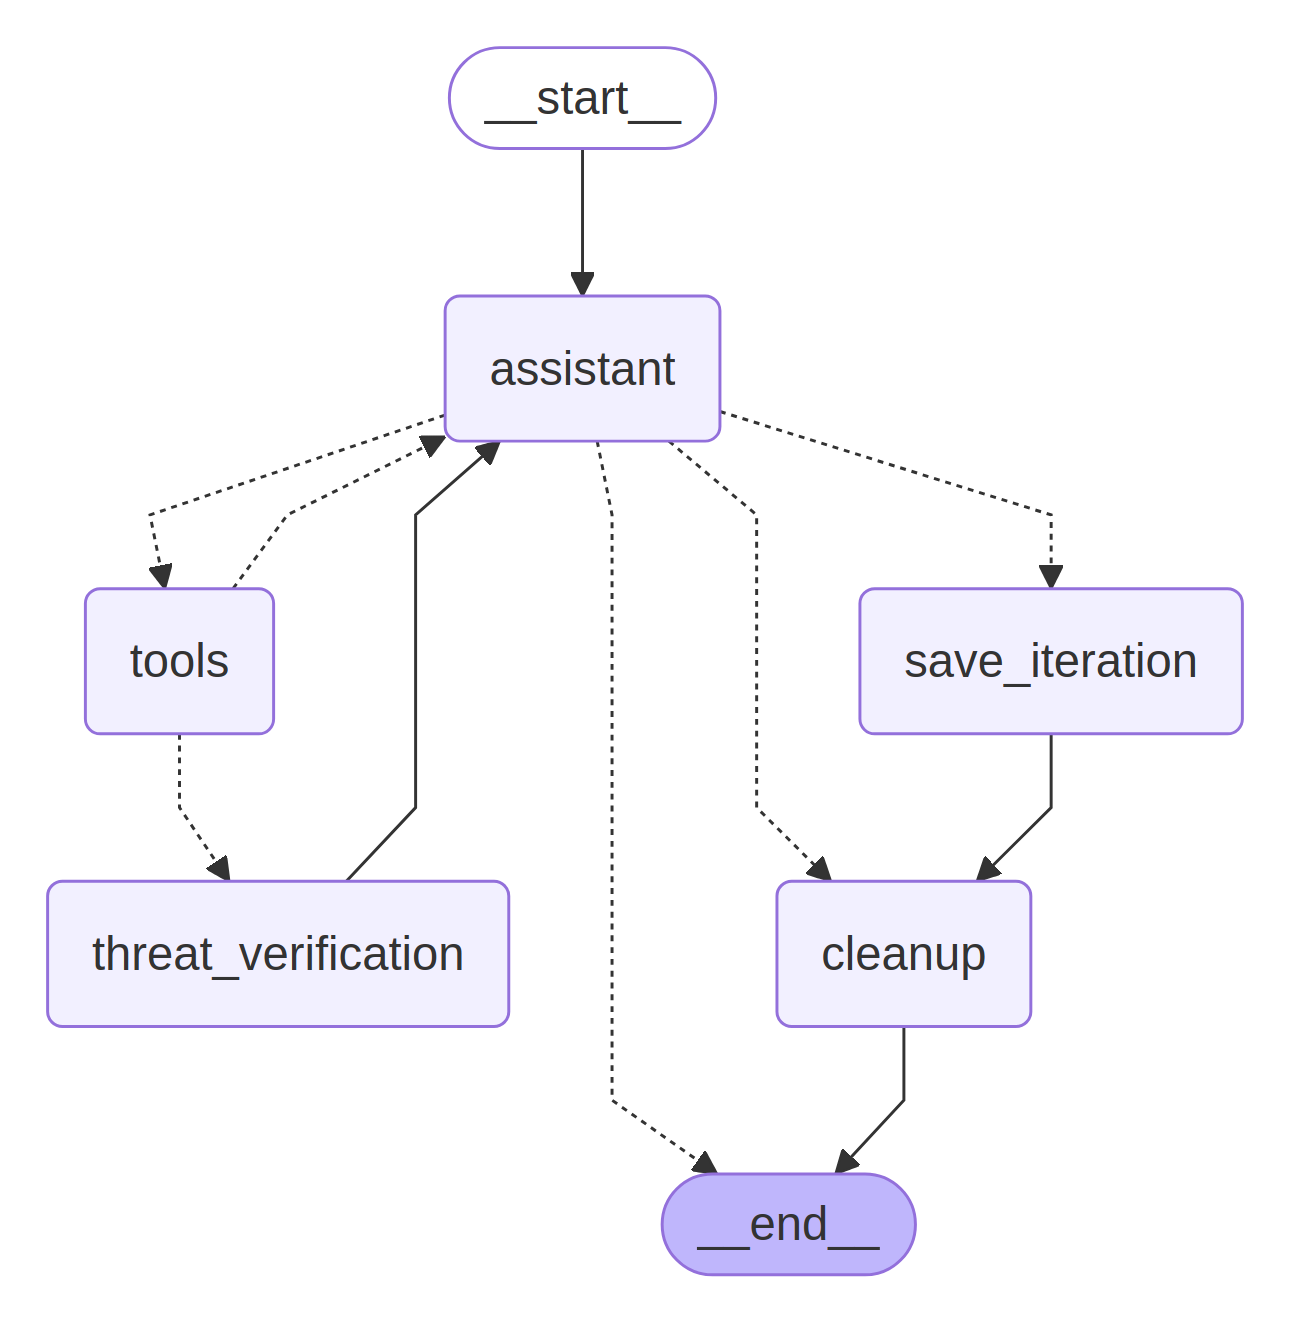

In [6]:
graph = build_react_graph()
display_graph(graph)

In [7]:
# Create an initial state
memory = EpisodicMemory()

In [17]:
initial_state = HoneypotStateReact(
    messages="Analyze a time_window=2 for all the tools and actually use the tool for adding firewall rules"
)
response = graph.invoke(initial_state, config={"configurable": {"store" : memory}})
for m in response['messages']:
    m.pretty_print()
for i in memory.get_recent_iterations():
    print(i.value["last_message"])

Loaded 5 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Memory: Iteration saved with ID iteration_6. Total iterations: 6
Performing complete cleanup before ending iteration...
Flushing all messages and resetting state for next iteration
Executing Honeypot Firewall Guardian Protocol...

```
## ITERATION SUMMARY

**HONEYPOT STATUS:**
- **Currently Exposed:** 172.20.0.2:2375, 172.20.0.2:2376 ("unauthorized-rce-docker-1")
- **Exploitation Level:** 33% (EXPOSED)
- **Evidence Summary:** Attacker 192.168.100.2 continues system and network reconnaissance—ARP and service enumeration only. No signs of exploitation, code execution, reverse shells, or privilege escalation. No malicious payloads or exploitation attempts in packet or flow logs.

**FIREWALL ACTIONS:**
- **Rules Applied:**
  - add_allow_rule(source_ip=192.168.100.2, dest_ip=172.20.0.2, port=2375, protocol='tcp')
  - add_allow_rule(source_ip=172.20.0.2, dest_ip=192.168.100.2, port=None, protocol='tcp')
  - add_allow_rule(source_ip=192.168.100.2, dest_ip=172.20.0.2, port=2376, protocol='tcp'

# Benchmark

In [8]:
config_dict = {
            "max_epochs": 10,
            "attack_duration": 300,
            "monitor_accumulation_wait": 3,
            "firewall_update_wait": 1,
            "between_epoch_wait": 3,
            "stop_on_lockdown": True,
        }

In [10]:
runner = b.BenchmarkRunner(config_dict)

def my_agent_executor(epoch_num: int):
    print(f"Executing agent for epoch {epoch_num}")
    initial_state = HoneypotStateReact(
        messages = "Analyze a time_window=2 for all the tools and actually use the tool for adding firewall rules",
    )
    return graph.invoke(initial_state, config={"configurable": {"store" : memory}})

results = runner.run(my_agent_executor)

INFO:benchmark.Orchestrator:Starting benchmark run


INFO:benchmark.AttackerController:Found existing attacker container: attacker
INFO:benchmark.AttackerController:Successfully connected to attacker container
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 1 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 300s...
INFO:benchmark.Orchestrator:Attack script running with a fallback timeout of 300s...


[ATTACK-1] [*] Attacker IP address: 192.168.100.2
[*] Launching exploit manager...
[*] Scanning 172.20.0.0/27 for open ports...


INFO:benchmark.Orchestrator:Attack script completed before timeout.
INFO:benchmark.Orchestrator:=== Phase: MONITORING_ACCUMULATION ===
INFO:benchmark.Orchestrator:Accumulating monitoring data for 3s...


[ATTACK-1] 
[+] Detected vulnerable services:

[ATTACK-1] Service    Target    Port    Path    Version
---------  --------  ------  ------  ---------

[ATTACK-1] 
=== 🏁 Flags Summary ===
[*] Exploit executed successfully


INFO:benchmark.Orchestrator:=== Phase: AGENT_ANALYSIS ===


Executing agent for epoch 1


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:benchmark.Orchestrator:=== Phase: FIREWALL_UPDATE_WAIT ===
INFO:benchmark.Orchestrator:Waiting 1s for firewall updates...


Memory: Iteration saved with ID iteration_1. Total iterations: 1
Performing complete cleanup before ending iteration...
Flushing all messages and resetting state for next iteration


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/20250627_122023/epoch_001.json
INFO:benchmark.Orchestrator:Waiting 3s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 2 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 300s...
INFO:benchmark.Orchestrator:Attack script running with a fallback timeout of 300s...


[ATTACK-2] [*] Attacker IP address: 192.168.100.2
[*] Launching exploit manager...
[*] Scanning 172.20.0.0/27 for open ports...
[ATTACK-2] [+] Host 172.20.0.5 has open ports: [('80', 'http')]
[*] Checking port 80 for GitLab...
[ATTACK-2] [*] Checking port 80 for Struts...
[ATTACK-2] [+] Host 172.20.0.6 has open ports: [('80', 'http')]
[*] Checking port 80 for GitLab...
[ATTACK-2] [*] Checking port 80 for Struts...
[ATTACK-2] Checking if version is vulnerable: 13.12.3

[+] Detected vulnerable services:

[ATTACK-2] Service    Target        Port  Path                  Version
---------  ----------  ------  --------------------  ---------
GITLAB     172.20.0.6      80  http://172.20.0.6:80  13.12.3

[ATTACK-2] [>>>] Launching GitLab exploit against http://172.20.0.6:80 (version: 13.12.3)[ATTACK-2] 
[ATTACK-2] GITLAB >> ['/attacker/scripts/gitlab/gitlab_exploit.py', 'http://172.20.0.6:80', '192.168.100.2']
GITLAB >> [*] Starting scan and exploit chain...
[ATTACK-2] GITLAB >> [*] Starting ne

INFO:benchmark.Orchestrator:Attack script completed before timeout.
INFO:benchmark.Orchestrator:=== Phase: MONITORING_ACCUMULATION ===
INFO:benchmark.Orchestrator:Accumulating monitoring data for 3s...


[ATTACK-2] GITLAB >> [<] Response:
GITLAB >> flag{root_access}
GITLAB >> 
GITLAB >> [*] Listener closed
[ATTACK-2] 
=== 🏁 Flags Summary ===
GITLAB: flag{user_access}
GITLAB: flag{root_access}
[*] Exploit executed successfully


INFO:benchmark.Orchestrator:=== Phase: AGENT_ANALYSIS ===


Executing agent for epoch 2
Loaded 1 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing packets and verifying detected threats...
Processing 2 chunks for comprehensive analysis...
Analyzing chunk 1/2...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing chunk 2/2...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:benchmark.Orchestrator:=== Phase: FIREWALL_UPDATE_WAIT ===
INFO:benchmark.Orchestrator:Waiting 1s for firewall updates...


Memory: Iteration saved with ID iteration_2. Total iterations: 2
Performing complete cleanup before ending iteration...
Flushing all messages and resetting state for next iteration


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/20250627_122023/epoch_002.json
INFO:benchmark.Orchestrator:Waiting 3s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 3 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 300s...
INFO:benchmark.Orchestrator:Attack script running with a fallback timeout of 300s...


[ATTACK-3] [*] Attacker IP address: 192.168.100.2
[*] Launching exploit manager...
[*] Scanning 172.20.0.0/27 for open ports...
[ATTACK-3] [+] Host 172.20.0.6 has open ports: [('80', 'http')]
[*] Checking port 80 for GitLab...
[ATTACK-3] [*] Checking port 80 for Struts...
[ATTACK-3] Checking if version is vulnerable: 13.12.3

[+] Detected vulnerable services:

[ATTACK-3] Service    Target        Port  Path                  Version
---------  ----------  ------  --------------------  ---------
GITLAB     172.20.0.6      80  http://172.20.0.6:80  13.12.3

[ATTACK-3] [>>>] Launching GitLab exploit against http://172.20.0.6:80 (version: 13.12.3)
[ATTACK-3] GITLAB >> ['/attacker/scripts/gitlab/gitlab_exploit.py', 'http://172.20.0.6:80', '192.168.100.2']
GITLAB >> [*] Starting scan and exploit chain...
GITLAB >> [*] Starting network listener script
[ATTACK-3] GITLAB >> [*] Waiting 5 seconds before triggering the connection...
[ATTACK-3] GITLAB >> [*] Setting up listener on 0.0.0.0:9001
GITLA

INFO:benchmark.Orchestrator:=== Phase: MONITORING_ACCUMULATION ===
INFO:benchmark.Orchestrator:Accumulating monitoring data for 3s...
INFO:benchmark.Orchestrator:=== Phase: AGENT_ANALYSIS ===


Executing agent for epoch 3
Loaded 2 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing packets and verifying detected threats...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:benchmark.Orchestrator:=== Phase: FIREWALL_UPDATE_WAIT ===
INFO:benchmark.Orchestrator:Waiting 1s for firewall updates...


Memory: Iteration saved with ID iteration_3. Total iterations: 3
Performing complete cleanup before ending iteration...
Flushing all messages and resetting state for next iteration


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/20250627_122023/epoch_003.json
INFO:benchmark.Orchestrator:Waiting 3s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 4 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 300s...
INFO:benchmark.Orchestrator:Attack script running with a fallback timeout of 300s...


[ATTACK-4] [*] Attacker IP address: 192.168.100.2
[*] Launching exploit manager...
[*] Scanning 172.20.0.0/27 for open ports...
[ATTACK-4] [+] Host 172.20.0.2 has open ports: [('8080', 'http-proxy')]
[*] Checking port 8080 for GitLab...
[ATTACK-4] [*] Checking port 8080 for Struts...
[ATTACK-4] Testing path: struts-showcase
[ATTACK-4] Testing path: examples
[ATTACK-4] Testing path: struts-examples
[ATTACK-4] Testing path: struts2-examples
[ATTACK-4] Testing path: struts2-showcase
Vulnerable path detected: struts2-showcase
[ATTACK-4] [+] Host 172.20.0.6 has open ports: [('80', 'http')]
[*] Checking port 80 for GitLab...
[ATTACK-4] [*] Checking port 80 for Struts...
[ATTACK-4] Checking if version is vulnerable: 13.12.3

[+] Detected vulnerable services:

[ATTACK-4] Service    Target        Port  Path                  Version
---------  ----------  ------  --------------------  ---------
STRUTS     172.20.0.2    8080  struts2-showcase
GITLAB     172.20.0.6      80  http://172.20.0.6:80  1

INFO:benchmark.Orchestrator:=== Phase: MONITORING_ACCUMULATION ===
INFO:benchmark.Orchestrator:Accumulating monitoring data for 3s...
INFO:benchmark.Orchestrator:=== Phase: AGENT_ANALYSIS ===


Executing agent for epoch 4
Loaded 3 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing packets and verifying detected threats...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:benchmark.Orchestrator:=== Phase: FIREWALL_UPDATE_WAIT ===
INFO:benchmark.Orchestrator:Waiting 1s for firewall updates...


Memory: Iteration saved with ID iteration_4. Total iterations: 4
Performing complete cleanup before ending iteration...
Flushing all messages and resetting state for next iteration


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/20250627_122023/epoch_004.json
INFO:benchmark.Orchestrator:Waiting 3s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 5 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 300s...
INFO:benchmark.Orchestrator:Attack script running with a fallback timeout of 300s...


[ATTACK-5] [*] Attacker IP address: 192.168.100.2
[*] Launching exploit manager...
[*] Scanning 172.20.0.0/27 for open ports...
[ATTACK-5] [+] Host 172.20.0.2 has open ports: [('8080', 'http-proxy')]
[*] Checking port 8080 for GitLab...
[ATTACK-5] [*] Checking port 8080 for Struts...
[ATTACK-5] Testing path: struts-showcase
[ATTACK-5] Testing path: examples
[ATTACK-5] Testing path: struts-examples
[ATTACK-5] Testing path: struts2-examples
[ATTACK-5] Testing path: struts2-showcase
Vulnerable path detected: struts2-showcase
[ATTACK-5] [+] Host 172.20.0.6 has open ports: [('80', 'http')]
[*] Checking port 80 for GitLab...
[ATTACK-5] [*] Checking port 80 for Struts...
[ATTACK-5] Checking if version is vulnerable: 13.12.3

[+] Detected vulnerable services:

[ATTACK-5] Service    Target        Port  Path                  Version
---------  ----------  ------  --------------------  ---------
STRUTS     172.20.0.2    8080  struts2-showcase
GITLAB     172.20.0.6      80  http://172.20.0.6:80  1

INFO:benchmark.Orchestrator:Attack script completed before timeout.
INFO:benchmark.Orchestrator:=== Phase: MONITORING_ACCUMULATION ===
INFO:benchmark.Orchestrator:Accumulating monitoring data for 3s...


[ATTACK-4] STRUTS >> [<] Response:
STRUTS >> cat /root/root.txt
STRUTS >> flag{second_stage_completed}
STRUTS >> root@d14d6e00fb8c:/usr/local/tomcat#
[ATTACK-4] STRUTS >> [+] Exploit executed
[ATTACK-5] STRUTS >> [+] Exploit executed
[ATTACK-4] 
=== 🏁 Flags Summary ===
STRUTS: flag{second_stage_completed}
[*] Exploit executed successfully
[ATTACK-5] STRUTS >> [ERR] Exception in thread Thread-1 (start_http_server):
STRUTS >> [ERR] Traceback (most recent call last):
STRUTS >> [ERR] File "/usr/lib/python3.13/threading.py", line 1041, in _bootstrap_inner
STRUTS >> [ERR] self.run()
STRUTS >> [ERR] ~~~~~~~~^^
STRUTS >> [ERR] File "/usr/lib/python3.13/threading.py", line 992, in run
STRUTS >> [ERR] self._target(*self._args, **self._kwargs)
STRUTS >> [ERR] ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
STRUTS >> [ERR] File "/attacker/scripts/multi_step/struts_exploit.py", line 44, in start_http_server
STRUTS >> [ERR] with socketserver.TCPServer(("0.0.0.0", 8888), handler) as httpd:
STRUTS >> [ERR] 

INFO:benchmark.Orchestrator:=== Phase: AGENT_ANALYSIS ===


Executing agent for epoch 5
Loaded 4 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:benchmark.Orchestrator:=== Phase: FIREWALL_UPDATE_WAIT ===
INFO:benchmark.Orchestrator:Waiting 1s for firewall updates...


Memory: Iteration saved with ID iteration_5. Total iterations: 5
Performing complete cleanup before ending iteration...
Flushing all messages and resetting state for next iteration


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/20250627_122023/epoch_005.json
INFO:benchmark.Orchestrator:Waiting 3s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 6 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 300s...
INFO:benchmark.Orchestrator:Attack script running with a fallback timeout of 300s...


[ATTACK-6] [*] Attacker IP address: 192.168.100.2
[*] Launching exploit manager...
[*] Scanning 172.20.0.0/27 for open ports...
[ATTACK-6] [+] Host 172.20.0.6 has open ports: [('80', 'http')]
[*] Checking port 80 for GitLab...
[ATTACK-6] [*] Checking port 80 for Struts...


INFO:benchmark.Orchestrator:Attack script completed before timeout.
INFO:benchmark.Orchestrator:=== Phase: MONITORING_ACCUMULATION ===
INFO:benchmark.Orchestrator:Accumulating monitoring data for 3s...


[ATTACK-6] Checking if version is vulnerable: 13.12.3

[+] Detected vulnerable services:

[ATTACK-6] Service    Target        Port  Path                  Version
---------  ----------  ------  --------------------  ---------
GITLAB     172.20.0.6      80  http://172.20.0.6:80  13.12.3

[ATTACK-6] [>>>] Launching GitLab exploit against http://172.20.0.6:80 (version: 13.12.3)
[ATTACK-6] GITLAB >> ['/attacker/scripts/gitlab/gitlab_exploit.py', 'http://172.20.0.6:80', '192.168.100.2']
GITLAB >> [*] Starting scan and exploit chain...
GITLAB >> [*] Starting network listener script
[ATTACK-6] GITLAB >> [*] Waiting 5 seconds before triggering the connection...[*] Setting up listener on 0.0.0.0:9001
GITLAB >> 
GITLAB >> [!] Error in listener: [Errno 98] Address already in use
GITLAB >> [*] Listener closed
[ATTACK-6] 
=== 🏁 Flags Summary ===
[*] Exploit executed successfully


INFO:benchmark.Orchestrator:=== Phase: AGENT_ANALYSIS ===


Executing agent for epoch 6
Loaded 5 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing packets and verifying detected threats...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:benchmark.Orchestrator:=== Phase: FIREWALL_UPDATE_WAIT ===
INFO:benchmark.Orchestrator:Waiting 1s for firewall updates...


Memory: Iteration saved with ID iteration_6. Total iterations: 6
Performing complete cleanup before ending iteration...
Flushing all messages and resetting state for next iteration


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/20250627_122023/epoch_006.json
INFO:benchmark.Orchestrator:Waiting 3s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 7 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 300s...
INFO:benchmark.Orchestrator:Attack script running with a fallback timeout of 300s...


[ATTACK-7] [*] Attacker IP address: 192.168.100.2
[*] Launching exploit manager...
[*] Scanning 172.20.0.0/27 for open ports...
[ATTACK-7] [+] Host 172.20.0.6 has open ports: [('80', 'http')]
[*] Checking port 80 for GitLab...
[ATTACK-7] [*] Checking port 80 for Struts...


INFO:benchmark.Orchestrator:Attack script completed before timeout.
INFO:benchmark.Orchestrator:=== Phase: MONITORING_ACCUMULATION ===
INFO:benchmark.Orchestrator:Accumulating monitoring data for 3s...


[ATTACK-7] Checking if version is vulnerable: 13.12.3

[+] Detected vulnerable services:

[ATTACK-7] Service    Target        Port  Path                  Version
---------  ----------  ------  --------------------  ---------
GITLAB     172.20.0.6      80  http://172.20.0.6:80  13.12.3

[ATTACK-7] [>>>] Launching GitLab exploit against http://172.20.0.6:80 (version: 13.12.3)[ATTACK-7] 
[ATTACK-7] GITLAB >> ['/attacker/scripts/gitlab/gitlab_exploit.py', 'http://172.20.0.6:80', '192.168.100.2']
GITLAB >> [*] Starting scan and exploit chain...
GITLAB >> [*] Starting network listener script
GITLAB >> [*] Waiting 5 seconds before triggering the connection...[*] Setting up listener on 0.0.0.0:9001
GITLAB >> 
GITLAB >> [!] Error in listener: [Errno 98] Address already in use
GITLAB >> [*] Listener closed
[ATTACK-7] 
=== 🏁 Flags Summary ===
[*] Exploit executed successfully


INFO:benchmark.Orchestrator:=== Phase: AGENT_ANALYSIS ===


Executing agent for epoch 7
Loaded 5 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Exception ignored in: <urllib3.response.HTTPResponse object at 0x76f9d54307f0>
Traceback (most recent call last):
  File "/home/c0ff3k1ll3r/Desktop/Thesis/AI_Agent_for_honeypot_operations/HoneypotAgentApp/.venv/lib/python3.13/site-packages/urllib3/response.py", line 691, in close
    self._fp.close()
  File "/usr/lib/python3.13/http/client.py", line 432, in close
    super().close() # set "closed" flag
  File "/usr/lib/python3.13/http/client.py", line 445, in flush
    self.fp.flush()
ValueError: I/O operation on closed file.


Analyzing packets and verifying detected threats...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:benchmark.Orchestrator:=== Phase: FIREWALL_UPDATE_WAIT ===
INFO:benchmark.Orchestrator:Waiting 1s for firewall updates...


Memory: Iteration saved with ID iteration_7. Total iterations: 7
Performing complete cleanup before ending iteration...
Flushing all messages and resetting state for next iteration


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/20250627_122023/epoch_007.json
INFO:benchmark.Orchestrator:Waiting 3s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 8 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 300s...
INFO:benchmark.Orchestrator:Attack script running with a fallback timeout of 300s...


[ATTACK-8] [*] Attacker IP address: 192.168.100.2
[*] Launching exploit manager...
[*] Scanning 172.20.0.0/27 for open ports...
[ATTACK-8] [+] Host 172.20.0.6 has open ports: [('80', 'http')]
[*] Checking port 80 for GitLab...
[ATTACK-8] [*] Checking port 80 for Struts...


INFO:benchmark.Orchestrator:Attack script completed before timeout.
INFO:benchmark.Orchestrator:=== Phase: MONITORING_ACCUMULATION ===
INFO:benchmark.Orchestrator:Accumulating monitoring data for 3s...


[ATTACK-8] Checking if version is vulnerable: 13.12.3

[+] Detected vulnerable services:

[ATTACK-8] Service    Target        Port  Path                  Version
---------  ----------  ------  --------------------  ---------
GITLAB     172.20.0.6      80  http://172.20.0.6:80  13.12.3

[ATTACK-8] [>>>] Launching GitLab exploit against http://172.20.0.6:80 (version: 13.12.3)[ATTACK-8] 
[ATTACK-8] GITLAB >> ['/attacker/scripts/gitlab/gitlab_exploit.py', 'http://172.20.0.6:80', '192.168.100.2']
GITLAB >> [*] Starting scan and exploit chain...
GITLAB >> [*] Starting network listener script
[ATTACK-8] GITLAB >> [*] Waiting 5 seconds before triggering the connection...
[ATTACK-8] GITLAB >> [*] Setting up listener on 0.0.0.0:9001
[ATTACK-8] GITLAB >> [!] Error in listener: [Errno 98] Address already in use
GITLAB >> [*] Listener closed
[ATTACK-8] 
=== 🏁 Flags Summary ===
[*] Exploit executed successfully


INFO:benchmark.Orchestrator:=== Phase: AGENT_ANALYSIS ===


Executing agent for epoch 8
Loaded 5 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing packets and verifying detected threats...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:benchmark.Orchestrator:=== Phase: FIREWALL_UPDATE_WAIT ===
INFO:benchmark.Orchestrator:Waiting 1s for firewall updates...


Memory: Iteration saved with ID iteration_8. Total iterations: 8
Performing complete cleanup before ending iteration...
Flushing all messages and resetting state for next iteration


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/20250627_122023/epoch_008.json
INFO:benchmark.Orchestrator:Waiting 3s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 9 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 300s...
INFO:benchmark.Orchestrator:Attack script running with a fallback timeout of 300s...


[ATTACK-9] [*] Attacker IP address: 192.168.100.2
[*] Launching exploit manager...
[*] Scanning 172.20.0.0/27 for open ports...
[ATTACK-9] [+] Host 172.20.0.6 has open ports: [('80', 'http')]
[*] Checking port 80 for GitLab...
[ATTACK-9] [*] Checking port 80 for Struts...


INFO:benchmark.Orchestrator:Attack script completed before timeout.
INFO:benchmark.Orchestrator:=== Phase: MONITORING_ACCUMULATION ===
INFO:benchmark.Orchestrator:Accumulating monitoring data for 3s...


[ATTACK-9] Checking if version is vulnerable: 13.12.3

[+] Detected vulnerable services:

[ATTACK-9] Service    Target        Port  Path                  Version
---------  ----------  ------  --------------------  ---------
GITLAB     172.20.0.6      80  http://172.20.0.6:80  13.12.3

[ATTACK-9] [>>>] Launching GitLab exploit against http://172.20.0.6:80 (version: 13.12.3)
[ATTACK-9] GITLAB >> ['/attacker/scripts/gitlab/gitlab_exploit.py', 'http://172.20.0.6:80', '192.168.100.2']
GITLAB >> [*] Starting scan and exploit chain...
GITLAB >> [*] Starting network listener script
GITLAB >> [*] Waiting 5 seconds before triggering the connection...[*] Setting up listener on 0.0.0.0:9001
GITLAB >> 
[ATTACK-9] GITLAB >> [!] Error in listener: [Errno 98] Address already in use
GITLAB >> [*] Listener closed
[ATTACK-9] 
=== 🏁 Flags Summary ===
[*] Exploit executed successfully


INFO:benchmark.Orchestrator:=== Phase: AGENT_ANALYSIS ===


Executing agent for epoch 9
Loaded 5 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing packets and verifying detected threats...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:benchmark.Orchestrator:=== Phase: FIREWALL_UPDATE_WAIT ===
INFO:benchmark.Orchestrator:Waiting 1s for firewall updates...


Memory: Iteration saved with ID iteration_9. Total iterations: 9
Performing complete cleanup before ending iteration...
Flushing all messages and resetting state for next iteration


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/20250627_122023/epoch_009.json
INFO:benchmark.Orchestrator:Waiting 3s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 10 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 300s...
INFO:benchmark.Orchestrator:Attack script running with a fallback timeout of 300s...


[ATTACK-10] [*] Attacker IP address: 192.168.100.2
[*] Launching exploit manager...
[*] Scanning 172.20.0.0/27 for open ports...
[ATTACK-10] [+] Host 172.20.0.6 has open ports: [('80', 'http')]
[*] Checking port 80 for GitLab...
[ATTACK-10] [*] Checking port 80 for Struts...


INFO:benchmark.Orchestrator:Attack script completed before timeout.
INFO:benchmark.Orchestrator:=== Phase: MONITORING_ACCUMULATION ===
INFO:benchmark.Orchestrator:Accumulating monitoring data for 3s...


[ATTACK-10] Checking if version is vulnerable: 13.12.3

[+] Detected vulnerable services:

[ATTACK-10] Service    Target        Port  Path                  Version
---------  ----------  ------  --------------------  ---------
GITLAB     172.20.0.6      80  http://172.20.0.6:80  13.12.3

[ATTACK-10] [>>>] Launching GitLab exploit against http://172.20.0.6:80 (version: 13.12.3)
[ATTACK-10] GITLAB >> ['/attacker/scripts/gitlab/gitlab_exploit.py', 'http://172.20.0.6:80', '192.168.100.2']
GITLAB >> [*] Starting scan and exploit chain...
GITLAB >> [*] Starting network listener script
GITLAB >> [*] Waiting 5 seconds before triggering the connection...
GITLAB >> [*] Setting up listener on 0.0.0.0:9001
[ATTACK-10] GITLAB >> [!] Error in listener: [Errno 98] Address already in use
GITLAB >> [*] Listener closed
[ATTACK-10] 
=== 🏁 Flags Summary ===
[*] Exploit executed successfully


INFO:benchmark.Orchestrator:=== Phase: AGENT_ANALYSIS ===


Executing agent for epoch 10
Loaded 5 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing packets and verifying detected threats...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:benchmark.Orchestrator:=== Phase: FIREWALL_UPDATE_WAIT ===
INFO:benchmark.Orchestrator:Waiting 1s for firewall updates...


Memory: Iteration saved with ID iteration_10. Total iterations: 10
Performing complete cleanup before ending iteration...
Flushing all messages and resetting state for next iteration


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/20250627_122023/epoch_010.json
INFO:benchmark.Orchestrator:Saved report to benchmark_results/20250627_122023/benchmark_report.json
INFO:benchmark.Orchestrator:Cleaning up benchmark resources
INFO:benchmark.AttackerController:Stopped and removed attacker container


In [11]:
for message in memory.get_recent_iterations():
    print(message.value['last_message'])

Executing Honeypot Firewall Guardian Protocol...

```
## ITERATION SUMMARY

**HONEYPOT STATUS:**
- **Currently Exposed:** 172.20.0.2:8080 (Struts2)
- **Exploitation Level:** 100%
- **Evidence Summary:** 
  - In the last 2 minutes, continued detection of attacker 192.168.100.2 performing command execution, reverse shell attempts, direct system command execution, privilege escalation activities, and data exfiltration (as previously confirmed). No further escalation possible—full lifecycle achieved.
  - No novel threats or new compromise behaviors on any other honeypot; gitlab-proxy and GitLab remain in prior states.

**FIREWALL ACTIONS:**
- **Rules Applied:**
  - None newly added—Struts2 already in lockdown (all critical allow rules have been removed in previous lockdown, only residual ACCEPT for .2→attacker remains).
  - No block rules newly added, as global lockdown is already enforced on all exploited surfaces.

- **Justification:**
  - Attack graph for Struts2 is confirmed at 100% (p

# Benchmark with monitoring

In [ ]:
import asyncio
from IPython.display import display, clear_output
import pandas as pd

async def run_with_monitoring():
    runner = b.BenchmarkRunner({"max_epochs": 5})
    runner.set_agent_executor(my_agent_executor)
    
    # Start benchmark in background
    import threading
    benchmark_thread = threading.Thread(target=runner.run)
    benchmark_thread.start()
    
    # Monitor progress
    while benchmark_thread.is_alive():
        clear_output(wait=True)
        status = runner.get_current_status()
        
        if status["status"] == "running":
            display(f"Epoch: {status['current_epoch']}/{runner.config.max_epochs}")
            if status["latest_metrics"]:
                df = pd.DataFrame([status["latest_metrics"]])
                display(df[['epoch_number', 'lockdown_activated', 'attack_graph_coverage']])
        
        await asyncio.sleep(5)
    
    return runner.results

# Run with monitoring
results = await run_with_monitoring()

'Epoch: 1/5'

CancelledError: 

INFO:benchmark.Orchestrator:=== Phase: MONITORING_ACCUMULATION ===
INFO:benchmark.Orchestrator:Accumulating monitoring data for 30s...
INFO:benchmark.Orchestrator:=== Phase: AGENT_ANALYSIS ===
ERROR:benchmark.Orchestrator:Error in epoch 1: 'NoneType' object has no attribute 'get_recent_iterations'
INFO:benchmark.Orchestrator:Waiting 20s before next epoch...


Executing agent for epoch 1


INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 2 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Attack running for 60s...
ERROR:benchmark.AttackerController:Error executing attack: 404 Client Error for http+docker://localhost/v1.51/containers/eb98eba19f2641cb7495493070169d174ac1893870db5e4f2a3abc9df03e7eaf/exec: Not Found ("No such container: eb98eba19f2641cb7495493070169d174ac1893870db5e4f2a3abc9df03e7eaf")
